# Arbeidskrav 4 - Webscraping

## D1

### Introduksjon

I denne analysen undersøker vi hvorvidt oppgitt rekkevidde for elbiler (WLTP) samsvarer med faktisk rekkevidde målt under Motor.no sin store vintertest. Bilene ble testet i temperaturer fra 0°C til -10°C, og testen omfatter over 30 bilmodeller. Formålet er å identifisere avvik og vurdere hvorvidt produsentene leverer det de lover under krevende forhold.

### 1. Metode

#### Datainnsamling

Vi hentet data fra følgende artikkel:  
[https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132](https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132)

Ved hjelp av `requests`, `BeautifulSoup`, ble HTML-tabellen hentet og manuelt konvertert til en pandas `DataFrame`.

#### Datavask

- Kolonnen `WLTP-tall`, som inneholdt både rekkevidde og energiforbruk, ble delt i:
  - `WLTP_rekkevidde_km`
  - `WLTP_forbruk_kWh_per_100km`
- Kolonnen `STOPP` ble konvertert til `Faktisk_rekkevidde_km`
- Enheter som `km` og `kWh` ble fjernet fra selve verdiene og lagt til i kolonnenavnene
- Rader med manglende eller ugyldige verdier (f.eks. "x") ble fjernet

#### Forholdstall

En ny kolonne ble lagt til for å vise forholdet mellom faktisk rekkevidde og oppgitt rekkevidde: Forhold_faktisk_WLTP = Faktisk_rekkevidde_km / WLTP_rekkevidde_km
Dette gir en verdi mellom 0 og 1, hvor 1 tilsvarer full oppnåelse av WLTP.

### 2. Analyse

#### Regresjonsmodell

Vi brukte en lineær regresjon med WLTP-rekkevidde som uavhengig variabel og faktisk rekkevidde som avhengig. Modellen følger formen: $f(x) = a * x + b$
Dette ble implementert med `LinearRegression` fra `scikit-learn`.

#### Visualisering

To plott ble laget:

1. **Plott uten origo**, som viser datasettet i sitt naturlige område.
2. **Plott med origo**, for å undersøke hvordan valg av y-akse kan påvirke inntrykket.

Begge plott inneholder:

- Datapunkter
- Regresjonslinje
- Aksetekster, tittel og forklaring

### 3. Funn

- Alle bilene leverte lavere rekkevidde enn oppgitt WLTP.
- Regresjonsmodellen bekrefter at WLTP fortsatt gir en indikasjon på rekkefølge, men ikke på nøyaktig rekkevidde i vinterklima.
- Forholdstallet mellom faktisk og oppgitt rekkevidde lå typisk mellom 0.7 og 0.9.

#### Eksempler:

- Tesla Model 3 LR: 614 km oppgitt → 521 km faktisk (avvik: -15,15 %)
- Skoda Enyaq iV80: 509 km → 347 km (avvik: -31,83 %)
- Polestar 2 LR Dual Motor: 476 km → 340 km (avvik: -28,57 %)

#### Gjennomsnittlig avvik

Den gjennomsnittlige prosentvise reduksjonen i rekkevidde var: $≈ 15.91 %$


### 4. Diskusjon

#### Forholdstall og "Avvik"

`Forhold_faktisk_WLTP` og "Avvik" måler samme fenomen, men forholdstallet er lettere å bruke videre i modellering. Det gir også et mer nøytralt, skalerbart tall mellom 0 og 1.

#### Tukling med y-aksen?

Ved å bruke både plott med og uten origo, unngår vi misvisende fremstilling. Uten origo kan forskjeller fremstå større enn de faktisk er.

#### Leverandørenes troverdighet

Under vinterforhold holder ingen biler det de lover – men det er en konsistent lineær sammenheng. Det tyder på at bilene skalerer logisk, men WLTP-tallene er for optimistiske i kulde.

### 5. Konklusjon

- Produsentene oppgir rekkevidder som ikke oppnås under vinterlige forhold.
- Gjennomsnittlig faktisk rekkevidde var ca. 84 % av oppgitt.
- Forbrukere bør ta høyde for 15–30 % tap i rekkevidde ved kjøring om vinteren.
- Det bør bli vanlig å oppgi en vinterrekkevidde i tillegg til WLTP-tall.

---

*Analysen ble gjennomført med Python, pandas, BeautifulSoup, scikit-learn og matplotlib.*






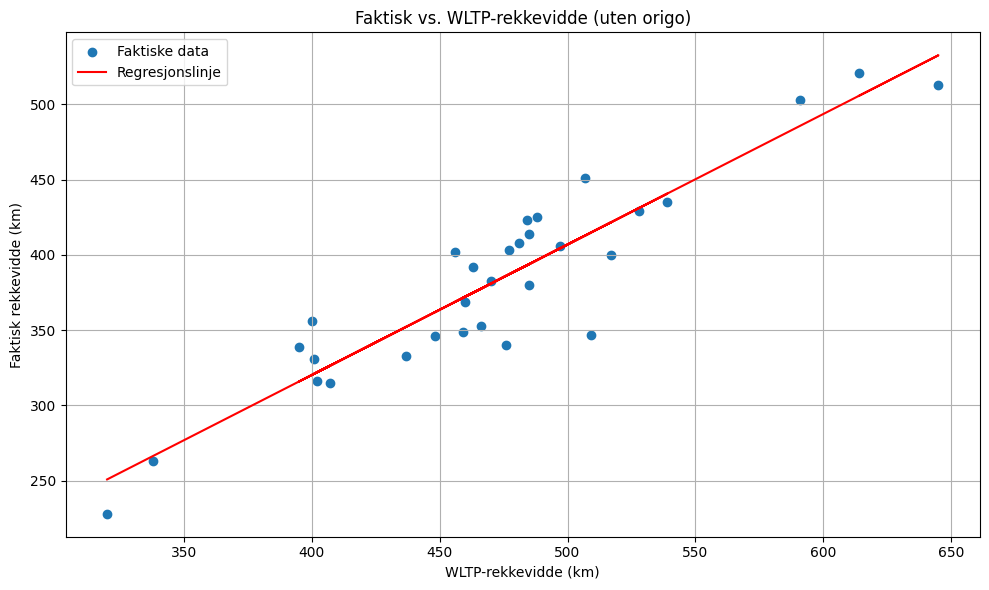

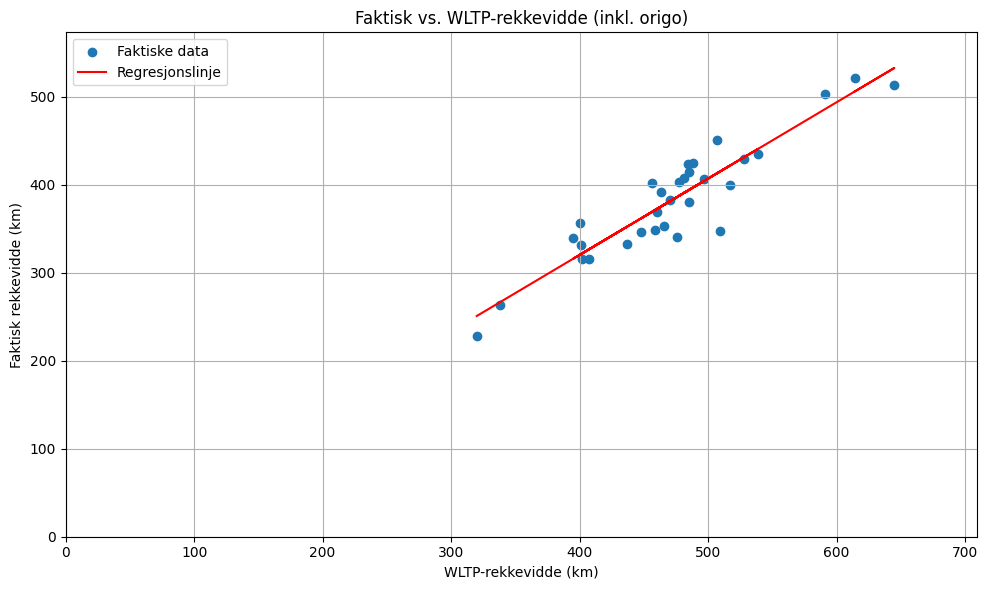

Gjennomsnittlig negativt avvik fra WLTP: 19.07 %


In [ ]:
#D2
import requests
from bs4 import BeautifulSoup
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression

#henter og parser HTML-tabell
def fetch_html_tables(url):
    """Henter HTML-tabeller fra en nettside med BeautifulSoup."""
    response = requests.get(url)
    soup = BeautifulSoup(response.content, 'html.parser')
    tables = soup.find_all('table')
    return tables

def html_table_to_list(table_html):
    """Konverterer en HTML-tabell til liste av rader."""
    table_data = []
    rows = table_html.find_all('tr')
    for row in rows:
        cells = row.find_all(['th', 'td'])
        row_data = [cell.get_text(strip=True) for cell in cells]
        table_data.append(row_data)
    return table_data

#henter tabellene fra Motor.no
url = 'https://www.motor.no/aktuelt/motors-store-vintertest-av-rekkevidde-pa-elbiler/217132'
tables = fetch_html_tables(url)

#vi antar den første tabellen er den relevante
table_data = html_table_to_list(tables[0])

#lager DataFrame
df = pd.DataFrame(table_data[1:], columns=table_data[0])

#datavask og tilrettelegging
#bytter komma til punktum i WLTP-tall (norsk til engelsk desimal)
df['WLTP-tall'] = df['WLTP-tall'].str.replace(',', '.', regex=False)

#deler WLTP-tall til to nye kolonner: WLTP km og energiforbruk
df[['WLTP_rekkevidde_km', 'WLTP_forbruk_kWh_per_100km']] = df['WLTP-tall'].str.extract(r'(\d+)\s*km/(\d+\.\d+)')

#henter faktisk rekkevidde fra STOPP-kolonnen
df['Faktisk_rekkevidde_km'] = df['STOPP'].str.extract(r'(\d+)').astype(float)

#konverter til numeriske verdier
df['WLTP_rekkevidde_km'] = pd.to_numeric(df['WLTP_rekkevidde_km'], errors='coerce')
df['WLTP_forbruk_kWh_per_100km'] = pd.to_numeric(df['WLTP_forbruk_kWh_per_100km'], errors='coerce')

#fjerner rader med manglende eller ugyldige verdier
df.dropna(subset=['WLTP_rekkevidde_km', 'Faktisk_rekkevidde_km'], inplace=True)

#lager forholdstall
df['Forhold_faktisk_WLTP'] = df['Faktisk_rekkevidde_km'] / df['WLTP_rekkevidde_km']

#lineær regresjonsmodell
X = df[['WLTP_rekkevidde_km']]
y = df['Faktisk_rekkevidde_km']

modell = LinearRegression()
modell.fit(X, y)

#legger til predikert verdi
df['Predikert_rekkevidde_km'] = modell.predict(X)

#plotter uten origo
plt.figure(figsize=(10, 6))
plt.scatter(df['WLTP_rekkevidde_km'], df['Faktisk_rekkevidde_km'], label='Faktiske data')
plt.plot(df['WLTP_rekkevidde_km'], df['Predikert_rekkevidde_km'], color='red', label='Regresjonslinje')
plt.xlabel('WLTP-rekkevidde (km)')
plt.ylabel('Faktisk rekkevidde (km)')
plt.title('Faktisk vs. WLTP-rekkevidde (uten origo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#plotter med origo
plt.figure(figsize=(10, 6))
plt.scatter(df['WLTP_rekkevidde_km'], df['Faktisk_rekkevidde_km'], label='Faktiske data')
plt.plot(df['WLTP_rekkevidde_km'], df['Predikert_rekkevidde_km'], color='red', label='Regresjonslinje')
plt.xlim(0, df['WLTP_rekkevidde_km'].max() * 1.1)
plt.ylim(0, df['Faktisk_rekkevidde_km'].max() * 1.1)
plt.xlabel('WLTP-rekkevidde (km)')
plt.ylabel('Faktisk rekkevidde (km)')
plt.title('Faktisk vs. WLTP-rekkevidde (inkl. origo)')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

#gjennomsnittlig avvik
avvik_prosent = (1 - df['Forhold_faktisk_WLTP']).mean() * 100
print(f"Gjennomsnittlig negativt avvik fra WLTP: {avvik_prosent:.2f} %")
